In [1]:
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from enum import Enum

(20985, 64, 64, 1) (20985, 8)
(5247, 64, 64, 1) (5247, 8)
(64, 64, 1)


<BarContainer object of 8 artists>

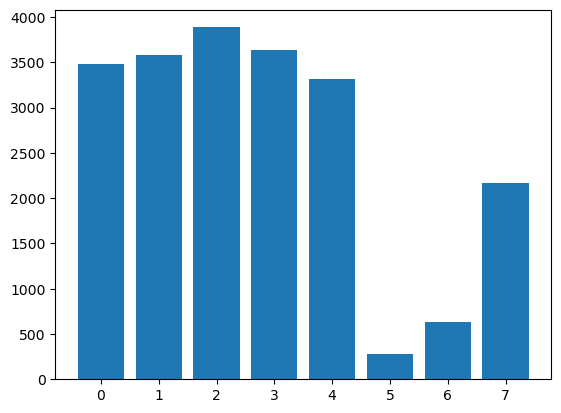

In [5]:
with open('kalman_data_slices.pickle', 'rb') as f:
    x, y = pickle.load(f)


class SampleType(Enum):
    BARTEK = 0
    KUBA = 1
    OSKAR = 2
    RAFAL = 3
    FAKE = 4
    NOISE = 5
    AUTO = 6
    WIATRAK = 7


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# add dimension to x
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
img_shape = x_test[0].shape

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(img_shape)

# count samples in each class, y_train is onehoted
y_t = np.argmax(y_train, axis=1)
unq, counts = np.unique(y_t, return_counts=True)

import matplotlib.pyplot as plt

plt.bar(unq, counts)


In [15]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

for k in [64, 128, 128, 128, 128]:
      model.add(Conv2D(k, (3,3), padding='same'))
      model.add(MaxPooling2D())
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Flatten())
for k in [512, 256, 128]:
      model.add(Dense(k))
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))
model.summary()


slice = Input(shape=img_shape)
pred = model(slice)
radar_model = Model(slice, pred)

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
]

early_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# optimizer = Adam(0.0002, 0.5)
radar_model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                        metrics=METRICS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_18 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                 

In [16]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot encoded labels to class indices
class_indices = np.argmax(y_train, axis=1)

# Get unique class labels
classes = np.unique(class_indices)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',classes=classes, y=class_indices)

# Convert class weights to a dictionary
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)

# dict of class with count
class_count = dict(zip(classes, np.bincount(class_indices)))

import math

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for id, key in enumerate(keys):
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[id] = score if score > 1.0 else 1.0
    
    return class_weight

class_weights_dict = create_class_weight(class_count)
class_weights_dict

{0: 0.7531223083548665, 1: 0.7312865904655701, 2: 0.6746720679012346, 3: 0.7216299862448419, 4: 0.791289592760181, 5: 9.538636363636364, 6: 4.1374211356466875, 7: 1.2099285055350553}


{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 2.4376720932152387,
 6: 1.602394236444584,
 7: 1.0}

In [18]:
history = radar_model.fit(x_train, y_train, validation_data=(x_test, y_test), class_weight=class_weights_dict, batch_size=128, epochs=100, callbacks=[early_callback])

Epoch 1/100
164/164 [==============================] - 91s 557ms/step - loss: 1.9583 - accuracy: 0.2419 - precision_2: 0.7289 - recall_2: 0.0359 - val_loss: 1.8032 - val_accuracy: 0.3242 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/100
164/164 [==============================] - 91s 554ms/step - loss: 1.6889 - accuracy: 0.3286 - precision_2: 0.8481 - recall_2: 0.1304 - val_loss: 1.6557 - val_accuracy: 0.3383 - val_precision_2: 0.9969 - val_recall_2: 0.0619
Epoch 3/100
164/164 [==============================] - 90s 546ms/step - loss: 1.4999 - accuracy: 0.3876 - precision_2: 0.8674 - recall_2: 0.1852 - val_loss: 1.2090 - val_accuracy: 0.4732 - val_precision_2: 0.9539 - val_recall_2: 0.2129
Epoch 4/100
164/164 [==============================] - 91s 553ms/step - loss: 1.2191 - accuracy: 0.4734 - precision_2: 0.8302 - recall_2: 0.2708 - val_loss: 0.9275 - val_accuracy: 0.5880 - val_precision_2: 0.9509 - val_recall_2: 0.3320
Epoch 5/100
164/164 [===========================

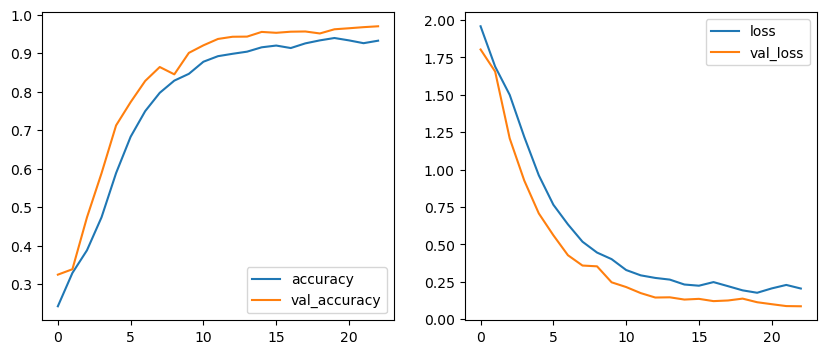

In [19]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(['accuracy', 'val_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss', 'val_loss'])
plt.show()

In [ ]:
radar_model.evaluate(x_test, y_test)


35/35 [==============================] - 5s 113ms/step - loss: 0.9104 - accuracy: 0.8874


[0.9104492664337158, 0.8874097466468811]

In [ ]:
np.unique(y, return_counts=True)

(array([0., 1.], dtype=float32), array([16608,  5536], dtype=int64))

164/164 [==============================] - 15s 39ms/step


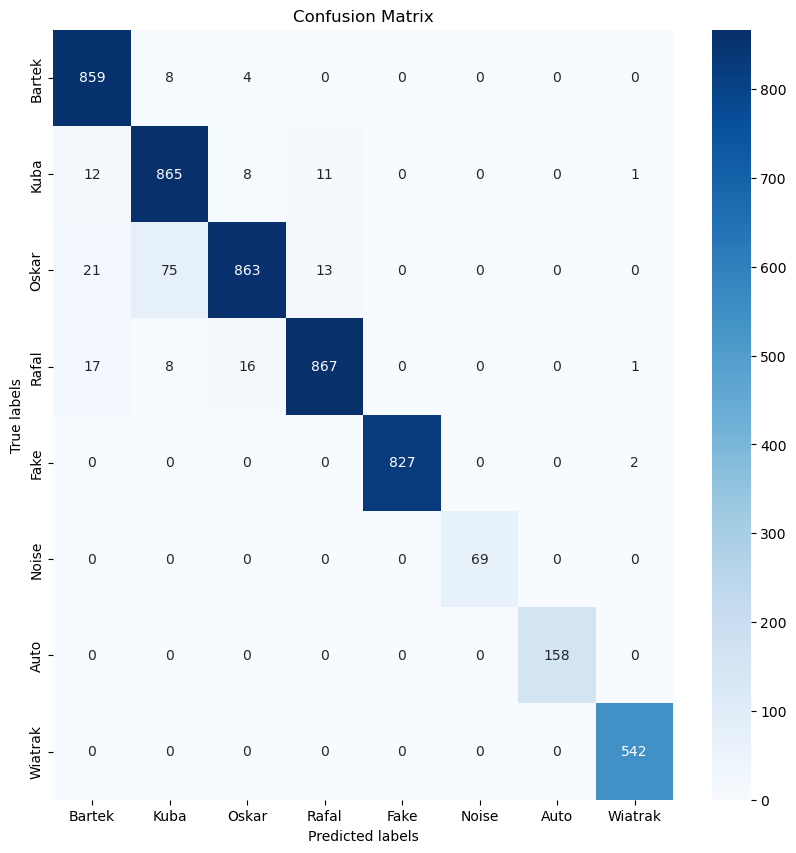

In [20]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = radar_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues',fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Bartek', 'Kuba', 'Oskar', 'Rafal', 'Fake', 'Noise', 'Auto', 'Wiatrak'])
ax.yaxis.set_ticklabels(['Bartek', 'Kuba', 'Oskar', 'Rafal', 'Fake', 'Noise', 'Auto', 'Wiatrak'])
plt.show()